In [ ]:
%%capture

!pip install qiskit[visualization]

In [ ]:
import qiskit
import numpy as np

from qiskit import Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, IBMQ
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.algorithms.optimizers import COBYLA
from qiskit.providers.ibmq import least_busy

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.operators import I, Z, X, Y

import matplotlib.pyplot as plt

In [ ]:
IBMQ.enable_account("8ee0cdbd442f6bb654b16a42a75546db448bed4a29f8874f7a3c96e4ba6381db750772327bbc111999756c30f142b957e3f6de4fb20c7622cf177b54c1df38c8")

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

## Functions

In [ ]:
def calculateOverlap(stateCoordinates1,stateCoordinates2):
    '''
    Calculates the overlap between two states, given their coordinates.

    Arguments:
      stateCoordinates1 (np.ndarray): the coordinates of one of the states in 
        some orthonormal basis,
      stateCoordinates2 (np.ndarray): the coordinates of the other state, in 
        the same basis

    Returns: 
      overlap (float): the overlap between two states (absolute value of the 
        inner product).
    '''

    bra = np.conj(stateCoordinates1)
    ket = stateCoordinates2
    overlap = np.abs(np.dot(bra,ket))
    
    return overlap

def callback(nfev, parameters, energy, stddev):
    '''
    Function to keep intermediary data from the optimization done by running
    the instance of the VQE class. Called at the end of each optimization run.

    Arguments:
      nfev (int): the number of function evaluations performed so far
      parameters (list): the parameters found by the optimizer in this 
        iteration
      energy (float):
      stddev (float):

    Returns: 
      No return value. Just fills the dictionary 'evolution', assumed to be 
        defined, with the data.
    '''

    evolution['nfev'].append(nfev)
    evolution['parameters'].append(parameters.copy())
    evolution['energy'].append(energy)
    evolution['stddev'].append(stddev)
    
    print("{}: {}".format(nfev,energy))

## Defining the Hamiltonian in Qiskit Aqua

In [ ]:
def toAquaObservable(operator):
  '''
  Transforms a Hamiltonian so that it's suitable for use
  with Qiskit Aqua

  Arguments:
    operator (dict): the Hamiltonian as a sum of Pauli strings,
      represented by a dictionary

  Returns:
    observable (qiskit.aqua.operators.OperatorBase): the observable
      as required by Aqua
  '''

  observable = 0

  for pauliString in operator:

    transformedPauli = 1
    for pauli in pauliString:
      if pauli == "I":
        transformedPauli = transformedPauli ^ I
      elif pauli == "X":
        transformedPauli = transformedPauli ^ X
      elif pauli == "Y":
        transformedPauli = transformedPauli ^ Y
      elif pauli == "Z":
        transformedPauli = transformedPauli ^ Z


    coefficient = operator[pauliString]
    observable += transformedPauli * coefficient

  return observable

In [ ]:
# Hamiltonian for HeH+ at r=90pm, from table 2 of the supplementary section
#of the original article.
hamiltonian90={
    "II": -3.8505,
    "IX": -0.2288,
    "IZ": -1.0466,
    "XI": -0.2288,
    "XX": +0.2613,
    "XZ": +0.2288,
    "ZI": -1.0466,
    "ZX": +0.2288,
    "ZZ": +0.2356
    }

# There's a strange factor of two in the table of the original article, that 
#causes the energy to be double what it should.
for key in hamiltonian90.keys():
  hamiltonian90[key] = hamiltonian90[key] / 2

hamiltonian = hamiltonian90

observable = toAquaObservable(hamiltonian)

print(observable)

SummedOp([
  -1.92525 * II,
  -0.1144 * IX,
  -0.5233 * IZ,
  -0.1144 * XI,
  0.13065 * XX,
  0.1144 * XZ,
  -0.5233 * ZI,
  0.1144 * ZX,
  0.1178 * ZZ
])


/usr/local/lib/python3.7/dist-packages/qiskit/aqua/operators/operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


## Ansatz (Full 2-qubit Hilbert Space)

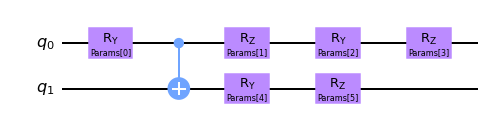

In [ ]:
# Define the parameter vector
params = ParameterVector("Params",6)

ansatz = QuantumCircuit(2)

# Apply parameterized gates
ansatz.ry(params[0],0)
ansatz.cx(0,1)
ansatz.rz(params[1],0)
ansatz.ry(params[2],0)
ansatz.rz(params[3],0)
ansatz.ry(params[4],1)
ansatz.rz(params[5],1)

ansatz.draw("mpl")

## Choosing the Backend

In [ ]:
# Check the accessible backends
provider = IBMQ.get_provider(hub='ibm-q-minho')
provider.backends()

In [ ]:
# Filter the backends that aren't simulators, have at least two qubits and
#are available

devices = provider.backends(filters=lambda x: x.configuration().n_qubits >= 2
                                    and not x.configuration().simulator
                                    and x.status().operational==True)

In [ ]:
# Check which one is the least busy
least_busy(devices)

<IBMQBackend('ibmq_manhattan') from IBMQ(hub='ibm-q-minho', group='academicprojects', project='quantalab')>

In [ ]:
# Choose

backend = Aer.get_backend('statevector_simulator')
#backend = provider.get_backend('ibmq_lima')

## Running VQE

In [ ]:
# Create empty evolution dictionary, to be filled with the data from each
#iteration
evolution = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

shots = 2**13
tol = 10**-2
qinstance = QuantumInstance(backend, shots = shots)

randomState = [np.random.rand() * np.pi for _ in range(6)]
randomState = [0.58871762, 2.52740039, 0.95600407, 2.65695065, 1.47913046, 2.58053004]


vqe = VQE(observable,
          var_form = ansatz, 
          optimizer = COBYLA(tol = tol), 
          quantum_instance = qinstance,
          callback = callback,
          initial_point = randomState)

result = vqe.run()

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/quantum_instance.py:137: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')
/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/vq_algorithm.py:72: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was moved/refactored to qiskit.algorithms.VariationalAlgorithm (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


1: -2.059527479020077
2: -1.9266433196018105
3: -2.1432981237452164
4: -1.5707029189685622
5: -2.1544142917301117
6: -1.7224534628015689
7: -2.0841625824774455
8: -2.6824744349729253
9: -2.8247430800233264
10: -2.517855497384611
11: -2.7603692771144144
12: -2.7982651215240613
13: -2.8211975326207015
14: -2.781712688425788
15: -2.761572960304558
16: -2.675581473228312
17: -2.8378883906648826
18: -2.840007085629539
19: -2.835909354720178
20: -2.84271608596779
21: -2.7798312531832656
22: -2.843114215639516
23: -2.8545041282439496
24: -2.838315971765259
25: -2.845043173065518
26: -2.8575990197792533
27: -2.859582339071141
28: -2.859193153467056
29: -2.8569688401880584
30: -2.85435633251592
31: -2.861159460160705
32: -2.860107272939235
33: -2.8609449879324043
34: -2.860020565216155
35: -2.8610250221971896
36: -2.859825957226935
37: -2.86110535242687
38: -2.859818603062794
39: -2.862283048069578
40: -2.8623218160901756
41: -2.8623282278839404
42: -2.86216627069302
43: -2.8622083975699035
44:

## Checking the Result

### Calculating Overlaps

In [ ]:
# Use Numpy to find the exact result
solver = NumPyMinimumEigensolver()
exactResult = solver.compute_minimum_eigenvalue(observable)

exactState = exactResult.eigenstate.to_matrix()
exactEnergy = exactResult.eigenvalue.real

# Use Aer to get the final state produced by the optimized
#ansatz circuit
finalParameters = evolution["parameters"][-1]
finalCircuit = ansatz.assign_parameters(finalParameters)
simulator = Aer.get_backend("statevector_simulator")

job = qiskit.execute(finalCircuit,simulator)
result = job.result()
finalState = result.get_statevector(finalCircuit, decimals=3)

# Check the overlap between the exact state and the final
#VQE state
print(calculateOverlap(exactState,finalState))

0.9998819363679626


/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')
/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


In [ ]:
overlaps = []

# Calculate the overlap with the ground state at each
#optimization step
for parameters in evolution["parameters"]:

  finalCircuit = ansatz.assign_parameters(parameters)
  simulator = Aer.get_backend("statevector_simulator")

  job = qiskit.execute(finalCircuit,simulator)
  result = job.result()
  finalState = result.get_statevector(finalCircuit, decimals=3)

  overlap = calculateOverlap(exactState,finalState)
  overlaps.append(overlap)

In [ ]:
# Attributing a name to the backend for the title of the plot

if backend.name() == "statevector_simulator":
  backendName = "Aer State Vector Simulator"

elif backend.name() == "qasm_simulator":
  backendName = "Aer QASM Simulator"

else:
  backendName = backend.name()

### Plotting Results

Text(0, 0.5, 'Overlap with the ground state')

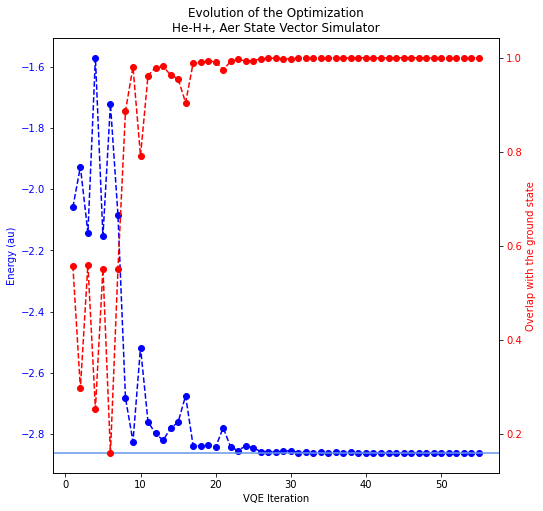

In [ ]:
fig, ax1 = plt.subplots(figsize=[8,8])

nfev = evolution["nfev"][-1]

title = "Evolution of the Optimization\nHe-H+, "

if backendName != "Aer State Vector Simulator":
  title += "{} shots, ".format(shots)
title += "{}".format(backendName)

ax1.set_title(title)

color1 = 'b'
ax1.plot(range(1,nfev+1), evolution["energy"], '--o', color = color1)
ax1.set_xlabel("VQE Iteration")
ax1.tick_params(axis='y', labelcolor = color1)
ax1.set_ylabel("Energy (au)", 
               color = color1)

plt.axhline(y = exactEnergy, color = 'cornflowerblue' , linestyle = '-')

color2 = 'r'
ax2 = ax1.twinx()
ax2.plot(range(1,nfev+1), overlaps, '--o', color = color2)
ax2.tick_params(axis='y', labelcolor = color2)
ax2.set_ylabel("Overlap with the ground state",
               color = color2)